# Whale Classification from echo-location clicks

In [8]:
from IPython.display import Image

This project is based on underwater sound data collected in the Gulf of Mexico during and since the time of the Deepwater Horizon oil spill in 2010. The task is to assess what species of whales were present at three recording sites, one near to the leaking well, and two others just outside the bounds of the spill. Here is a map of the Gulf of Mexico showing the recording site locations (dots) and the oiled area (gray).

Image[filename="intro.jpg"]

The classification was performed using the echo-location clicks emitted by beaked whales. These are very short pulses (less than a ms) that whales and dolphins use to sense their surroundings, including the detection of their prey. Different species of beaked whales emit clicks with different waveforms and spectral distributions. The time intervals between clicks also provides information about the species. Examples clicks from Cuvier’s and Gervais’ beaked whales are shown below.

Image[filename="Cuv_Ger.jpg"]

The task is simplified by the fact that whales usually occur in groups all belonging to the same species. The clicks can be separated into “runs” of clicks, each usually corresponding to a single species, separated by periods without clicks.

The classification was done by hand by Professor Hildebrand and became the basis for an estimate of the numbers of animals present at these sites. These results were presented in: Hildebrand, J. A., Baumann-Pickering, S., Frasier, K. E., Trickey, J. S., Merkens, K. P., Wiggins, S. M., McDonald, M. A., Garrison, L. P., Harris, D., Marques, T. A., and Thomas, L. (2015). "Passive acoustic monitoring of beaked whale densities in the Gulf of Mexico," Scientific Reports 5, 16343.

The goal of the proposed project is to create a classifier that takes as input data a run of clicks and outputs the species that is found in that run.

Beyond this project, there are many potential follow-up projects, related to analyzing various sounds emitted by marine mammals, including songs of baleen whales.

Peta-bytes of underwater audio data have been collected by Scripps and other oceanographic institutions, and the systematic analysis of these data is in it’s infancy. There is many opportunities for people with the relevant skills in big data analysis and signal processing to get involved in the process of discovering the information contained in sound and other oceanographic data.



In [9]:
%load_ext autoreload
%autoreload 2
%config IPCompleter.greedy=True

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Importing require dependencies and starting a spark context

In [12]:
from pyspark import SparkContext
sc = SparkContext(pyFiles=['lib/row_parser.py','lib/spark_PCA.py'])

from pyspark.sql import Row, SQLContext, DataFrame
from pyspark.sql.types import *

sqlContext = SQLContext(sc)

In [13]:
%pylab inline

import pandas as pd
import datetime as dt

from scipy.io import loadmat, savemat, whosmat

from collections import Counter
import re
import numpy as np
from numpy import shape

from glob import glob
from time import time
import sys
from row_parser import *
from spark_PCA import *
from pyspark.sql import DataFrame

Populating the interactive namespace from numpy and matplotlib


## Loading the Dataset

In [14]:
file_data = np.load("Data/whale_data_15mb.np")
file_data_rdd = sc.parallelize(file_data.tolist())

In [16]:
schema = StructType([
     StructField('time', TimestampType(), True),
     StructField('species', StringType(), True),
     StructField('site', StringType(), True),
     StructField('rec_no', StringType(), True),
     StructField('bout_i', LongType(), True),
     StructField('peak2peak', DoubleType(), True),
     StructField('MSN', BinaryType(), True),
     StructField('MSP', BinaryType(), True),
     StructField('TPWS1', LongType(), True),
     StructField('MD1', LongType(), True),
     StructField('FD1', LongType(), True),
     StructField('TPWS2', LongType(), True),
     StructField('MD2', LongType(), True),
     StructField('FD2', LongType(), True),
     StructField('TPWS3', LongType(), True),
     StructField('MD3', LongType(), True),
     StructField('FD3', LongType(), True)
])

### Format of cvs files
|field name     | Description               | Data Type
|---------------|---------------------------|--------------
|0: time        | time of click             | string in datetime format `%Y-%m-%d %H:%M:%S.%f`
|1: species		| Initial species classification	        | 'str'
|2: site		| name of site		        | 'str'
|3: rec_no		| recording number		    | 'str'
|4: bout_i		| bout number		        | numpy.int64
|5: peak2peak	| peak to peak magnitude    | 			numpy.float64
|6: MSN	        |	wave form |		 an array of length 202
|208: MSP		|	spectra |	 an array of length 101  
|309: TPWS1		| 1 if click appears in TPWS1	| 	bool
|310: MD1		|	--- " ---	in MD1|	bool
|311: FD1	    |	--- " ---	in FD1|	bool
|312: TPWS2		| 1 if click appears in TPWS2	| 	bool
|313: MD2		|	--- " ---	in MD2|	bool
|314: FD2	    |	--- " ---	in FD2|	bool
|315: TPWS3		| 1 if click appears in TPWS3	| 	bool
|316: MD3		|	--- " ---	in MD3|	bool
|317: FD3	    |	--- " ---	in FD3|	bool
total number of fields= 318

In [17]:
df_new = sqlContext.createDataFrame(file_data_rdd, schema).cache()

In [18]:
df_new.groupBy('species').count().collect()

[Row(species='Cuviers', count=2238), Row(species='Gervais', count=1937)]

In [19]:
def g(row):
    return unpackArray(row.MSP,data_type=numpy.float64)

## Mean and covariance

In [20]:
spectra=df_new.rdd.map(g)
COV=computeCov(spectra)

shape of E= (101,) shape of NE= (101,)


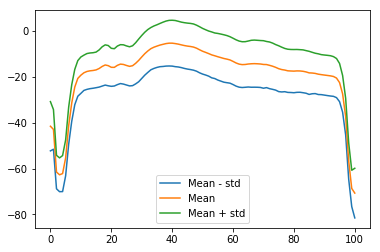

In [21]:
M=COV['Mean']
S=np.sqrt(COV['Var'])
plt.plot(M-S)
plt.plot(M)
plt.plot(M+S)
plt.legend(['Mean - std', 'Mean', 'Mean + std'])
plt.show()

## Eigen Vector Extraction

shape of E= (101,) shape of NE= (101,)
Plot for the first 10 Eigen Vectors


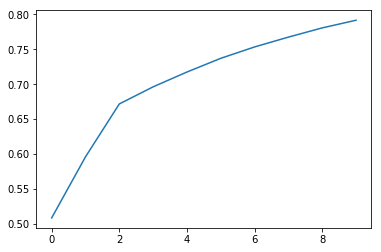

In [22]:
## Get Spectra
spectra=df_new.rdd.map(trimmed_spectra)

## Extract Eigen Vectors
COV=computeCov(spectra)
eigval,eigvec=LA.eig(COV['Cov'])
eigval=eigval/sum(eigval)

## Check the Reconstruction
print("Plot for the first 10 Eigen Vectors")
plot(cumsum(eigval[:10]))

## Visualizing the first 4 eigen vectors

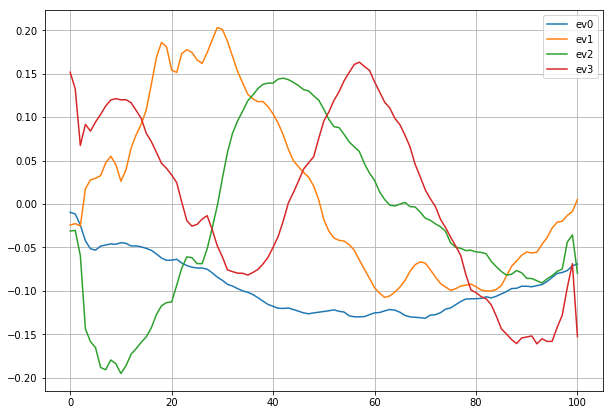

In [23]:
figure(figsize=[10,7])
for i in range(4):
    plot(eigvec[:,i],label='ev'+str(i))
legend()
grid()

In [24]:
sum(eigvec[:,1]**2)

0.9999999999999999

**Observations**: Can be seen that the sum of all eigen vectors is 1

In [25]:
## Using First 10 Eigen Vectors
V=eigvec[:,0:10]
## Defining a function to return Projection
def project(array):
    return np.dot(array, V)

## Creating Training Data

Returns the projection, rmse , peak2peak and the label 

In [26]:
def calc_stats(row):
    array = trimmed_spectra(row)
    projections = project(array)
    rmse = np.std(array)
    peak2peak = row.peak2peak
    label = 0 if row.species==u'Gervais' else 1
    return np.hstack((projections, [rmse, peak2peak, label]))

In [27]:
df_trimmed_data = df_new.rdd.map(calc_stats)

In [28]:
data = df_trimmed_data.collect()

## Writing Data

In [29]:
np_data = np.array(data)
np.save(open('Data/processed_data_15mb.np', 'wb'), np_data)

## Category Analysis

In [30]:
Cuviers=df_new.filter(df_new.TPWS2==1).filter(df_new.species==u'Cuviers')
Gervais=df_new.filter(df_new.TPWS2==1).filter(df_new.species==u'Gervais')

In [31]:
print("Total: ", Cuviers.count() + Gervais.count())
print("Cuviers: ", Cuviers.count())
print("Gervais: ", Gervais.count())

Total:  4175
Cuviers:  2238
Gervais:  1937


In [32]:
V=eigvec[:,1:3] #vectors on which to project, chose 1,2 eigen vectors
def project(row):
    X=unpackArray(row.MSP,data_type=np.float64)
    return np.dot(X,V)

## Scatter Plot
Scatter plot shows there are some points which are classified as a particular species in high confidence and the rest are unsure.

(0, 200)

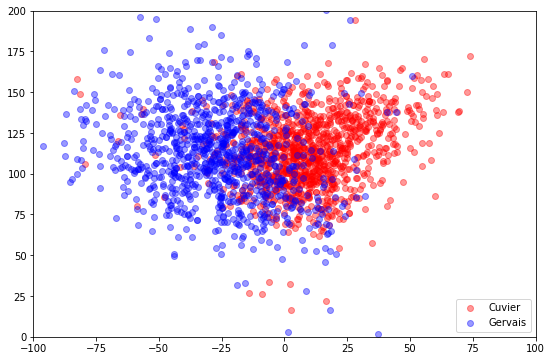

In [33]:
Cuvier_projections=np.array(Cuviers.sample(False,0.5).rdd.map(project).take(10000))
Gervais_projections=np.array(Gervais.sample(False,0.5).rdd.map(project).take(10000))

figure(figsize=[9,6])
scatter(Cuvier_projections[:,0],Cuvier_projections[:,1],c='r', alpha=0.4)
scatter(Gervais_projections[:,0],Gervais_projections[:,1],c='b', alpha=0.4)
legend(['Cuvier', 'Gervais'], loc="lower right")
xlim([-100,100])
ylim([0,200])

## Highlighting the area of importance

(75, 150)

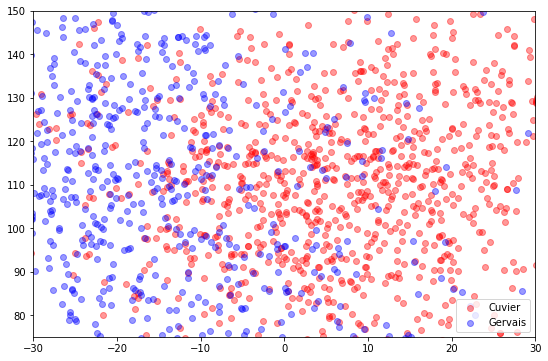

In [34]:
Cuvier_projections=np.array(Cuviers.sample(False,0.5).rdd.map(project).take(10000))
Gervais_projections=np.array(Gervais.sample(False,0.5).rdd.map(project).take(10000))


figure(figsize=[9,6])
scatter(Cuvier_projections[:,0],Cuvier_projections[:,1],c='r', alpha=0.4)
scatter(Gervais_projections[:,0],Gervais_projections[:,1],c='b', alpha=0.4)
legend(['Cuvier', 'Gervais'], loc="lower right")
xlim([-30, 30])
ylim([75, 150])